## Import Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Create Model

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
data_dir = pathlib.Path("D:\PACE\CSProject\Squander\dataset-resized")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6784 files belonging to 6 classes.
Using 5428 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6784 files belonging to 6 classes.
Using 1356 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


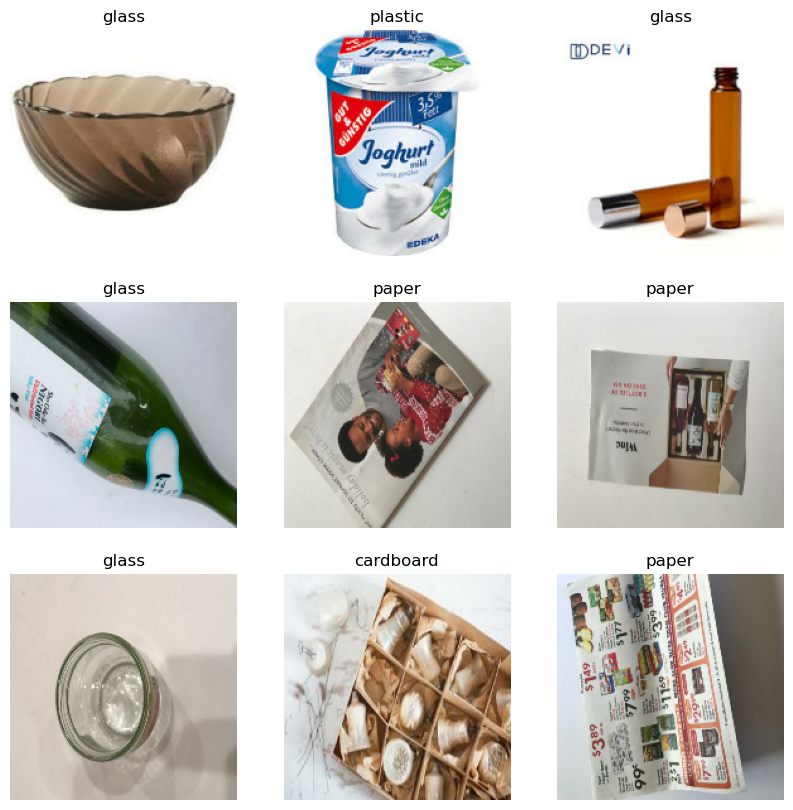

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
170/170 [==============================] - 33s 190ms/step - loss: 1.4752 - accuracy: 0.4398 - val_loss: 1.1178 - val_accuracy: 0.5701
Epoch 2/100
170/170 [==============================] - 31s 182ms/step - loss: 1.0599 - accuracy: 0.5949 - val_loss: 1.0603 - val_accuracy: 0.6062
Epoch 3/100
170/170 [==============================] - 37s 215ms/step - loss: 0.8401 - accuracy: 0.6887 - val_loss: 0.8794 - val_accuracy: 0.6689
Epoch 4/100
170/170 [==============================] - 34s 197ms/step - loss: 0.6450 - accuracy: 0.7686 - val_loss: 0.8121 - val_accuracy: 0.7161
Epoch 5/100
170/170 [==============================] - 37s 218ms/step - loss: 0.4779 - accuracy: 0.8307 - val_loss: 0.9022 - val_accuracy: 0.6947
Epoch 6/100
170/170 [==============================] - 31s 186ms/step - loss: 0.3499 - accuracy: 0.8775 - val_loss: 0.9127 - val_accuracy: 0.7338
Epoch 7/100
170/170 [==============================] - 32s 189ms/step - loss: 0.2622 - accuracy: 0.9081 - val_loss: 1.0153 -

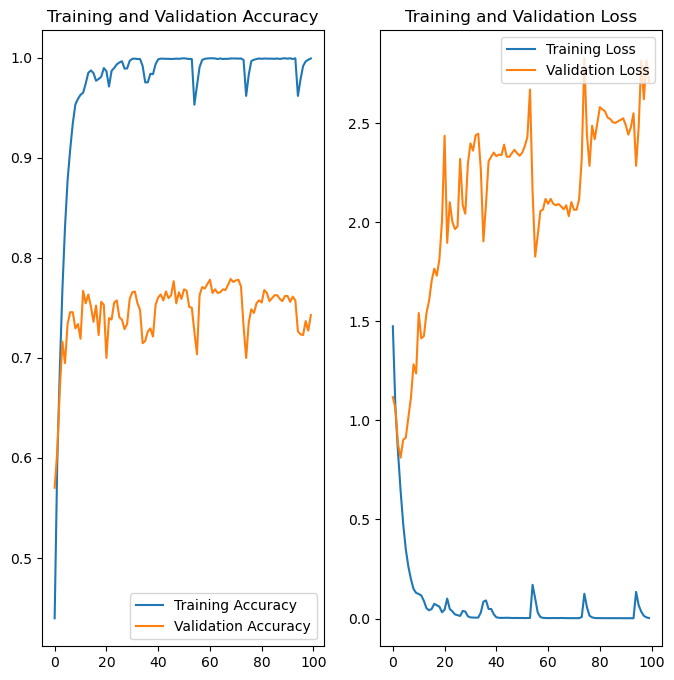

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 145ms/step
This image most likely belongs to plastic with a 100.00 percent confidence.


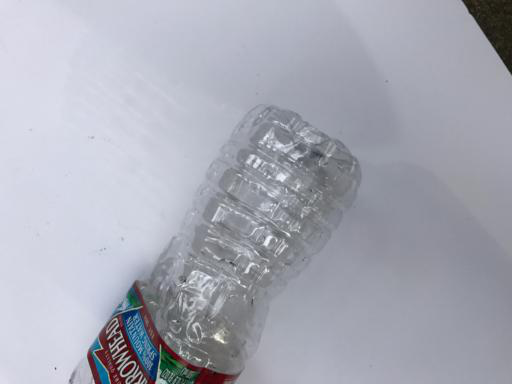

In [17]:
test_files = os.listdir( r"D:/PACE/CSProject/Squander/data/test/")
test_dir = r"D:/PACE/CSProject/Squander/data/test/"
test_path = test_dir + test_files[560]

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(test_path)

## Transfer Learning

In [18]:
print(image_batch)

tf.Tensor(
[[[[0.8434423  0.7610894  0.6787364 ]
   [0.8401308  0.7577778  0.6754249 ]
   [0.83681923 0.75446624 0.6721133 ]
   ...
   [0.5069208  0.44417572 0.38143063]
   [0.50104576 0.43830067 0.37555557]
   [0.49381262 0.43106753 0.3683224 ]]

  [[0.8434423  0.7610894  0.6787364 ]
   [0.8401308  0.7577778  0.6754249 ]
   [0.83681923 0.75446624 0.6721133 ]
   ...
   [0.50481474 0.44206968 0.3793246 ]
   [0.4973987  0.4346536  0.37190852]
   [0.4901961  0.427451   0.3647059 ]]

  [[0.8434423  0.7610894  0.6787364 ]
   [0.8401308  0.7577778  0.6754249 ]
   [0.83681923 0.75446624 0.6721133 ]
   ...
   [0.5019608  0.43921572 0.37647063]
   [0.49461877 0.43187365 0.36912856]
   [0.4868773  0.4241322  0.36138707]]

  ...

  [[0.8470589  0.76470596 0.6901961 ]
   [0.84797394 0.76562095 0.69111115]
   [0.83921576 0.7568628  0.68235296]
   ...
   [0.5821349  0.5233114  0.44880158]
   [0.5709803  0.5121568  0.43764699]
   [0.56013066 0.50130713 0.42679733]]

  [[0.8470589  0.76470596 0.690196

In [19]:
input_t = keras.Input(shape = (180,180,3))
res_model = keras.applications.ResNet50(include_top=False,
    weights='imagenet',
    input_tensor = input_t
)

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
for layer in res_model.layers[:143]:
    layer.trainable = False

In [21]:
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
num_classes = len(class_names)
model_2 = keras.models.Sequential()
model_2.add(res_model)
model_2.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_2.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model_2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model_2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model_2.add(layers.Flatten())
model_2.add( layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(num_classes))

In [28]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 rescaling_6 (Rescaling)     (None, 6, 6, 2048)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 16)          294928    
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 6, 32)          4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [30]:
epochs=100
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
170/170 [==============================] - 210s 1s/step - loss: 0.9297 - accuracy: 0.6350 - val_loss: 1.2134 - val_accuracy: 0.7559
Epoch 2/100
170/170 [==============================] - 203s 1s/step - loss: 0.3481 - accuracy: 0.8826 - val_loss: 0.3160 - val_accuracy: 0.8945
Epoch 3/100
170/170 [==============================] - 208s 1s/step - loss: 0.1681 - accuracy: 0.9425 - val_loss: 0.2977 - val_accuracy: 0.9130
Epoch 4/100
170/170 [==============================] - 214s 1s/step - loss: 0.1019 - accuracy: 0.9679 - val_loss: 0.4053 - val_accuracy: 0.8872
Epoch 5/100
170/170 [==============================] - 215s 1s/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.2574 - val_accuracy: 0.9336
Epoch 6/100
170/170 [==============================] - 215s 1s/step - loss: 0.0327 - accuracy: 0.9912 - val_loss: 0.2847 - val_accuracy: 0.9344
Epoch 7/100
170/170 [==============================] - 212s 1s/step - loss: 0.0680 - accuracy: 0.9788 - val_loss: 0.4300 - val_accuracy:

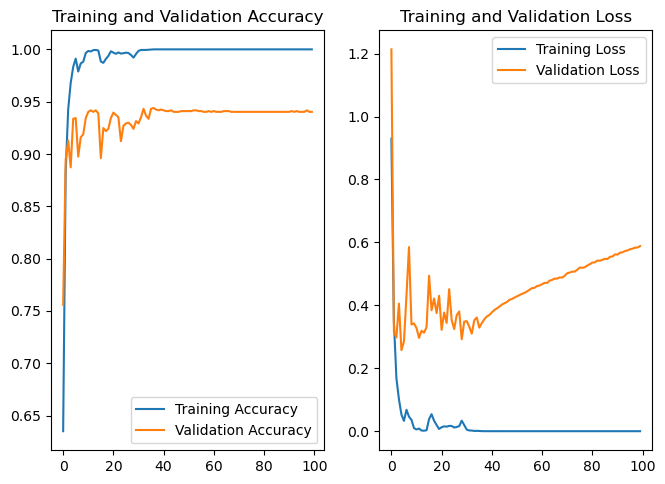

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(2, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Model

In [ ]:
Model_Directory = r"D:\PACE\CSProject\Squander\tmp"
version = 2

In [ ]:
export_path = os.path.join(Model_Directory, str(version))
print('export_path = {}\n'.format(export_path))

export_path = D:\PACE\CSProject\Squander\tmp\2



In [ ]:
#Save model
#model.save(export_path)
model.save("<TrashClassifyModel>",export_path, save_format="h5")
model.save("TrashClassifyModel.h5", save_format="h5")